In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.utils.constants import TARGET, MODEL_FEATURES
from src.utils.funcs import get_nrf_color_group

In [4]:
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# A note on choice of models

Model requirements:
   - Should be able to detect interactions without coding for interaction features
   - Should be able to handle new values of categorical features
   - Should generalise well and be less prone to overfitting

Decision trees are generally better at uncovering feature interactions without explicitly coding for them. Therefore, in interest of time, we will skip testing linear regression models but ideally, this should be done.

# Read in training data

In [36]:
train_path = data / "01_raw" / "train_raw.csv"
train = pd.read_parquet(train_path)

y_train = train.loc[:, [TARGET]]
X_train = train.loc[:, MODEL_FEATURES]

X_train.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,Sustainablity,MARKETING_CATEGORY,nrf_color_group
0,75.83,76.79,77.01,1,76.50,1
1,74.53,72.17,74.08,1,76.33,1
2,74.53,75.37,74.50,2,76.56,2
3,74.57,74.88,75.86,3,95.39,3
4,64.82,66.97,73.71,4,49.92,1


# Test data preprocessing

In [37]:
test_path = data / "01_raw" / "test_raw.csv"
test = pd.read_parquet(test_path)
test.shape

(12128, 7)

In [38]:
# Outlier removal at 216.0
train = test[test.Units_sold < 216]

# Feature nrf color group
test["nrf_color_group"] = test.apply(get_nrf_color_group, axis=1)

# Categorical encoding
oe_encoder_path = base_dir / "artifacts" / "oe_encoder.pkl"
file = open(oe_encoder_path, "rb")
oe_encoder = pickle.load(file)
test = oe_encoder.fit_transform(test)

encoder_path = base_dir / "artifacts" / "encoder.pkl"
file2 = open(encoder_path, "rb")
encoder = pickle.load(file2)
test = encoder.transform(test)
test.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
7,74.23,74.37,74.55,1.00,1,99.51,36,1
8,73.66,74.83,74.68,610.00,9,70.91,120,12
9,74.53,73.47,72.68,610.00,2,100.52,120,12
10,62.85,74.37,74.55,307.00,10,50.93,96,11
11,77.33,75.54,73.71,1.00,9,70.91,108,1


In [39]:
y_test = test.loc[:, [TARGET]]
X_test = test.loc[:, MODEL_FEATURES]

X_train.to_parquet(data / "02_intermediate/X_train.csv", index=None)
X_test.to_parquet(data / "02_intermediate/X_valid.csv", index=None)
y_train.to_parquet(data / "02_intermediate/y_train.csv", index=None)
y_test.to_parquet(data / "02_intermediate/y_valid.csv", index=None)

We will use evaluation metric: MAE

### Comparing various algorithms

Let us see whether bagging does better or boosting in this problem

#### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.1s


Training MAE: 30.68241352136043
Test MAE: 39.301360488126655


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

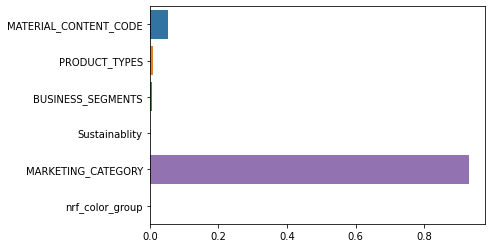

In [47]:
est_rf = RandomForestRegressor(
    criterion="absolute_error", max_depth=5, verbose=1, n_jobs=-1
)

est_rf.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[MODEL_FEATURES])
rf_pred_test = est_rf.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, rf_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, rf_pred_test)}")

sns.barplot(x=est_rf.feature_importances_, y=MODEL_FEATURES)

      Iter       Train Loss   Remaining Time 
         1          32.9619            4.39s
         2          32.6469            4.47s
         3          32.3624            4.74s
         4          32.1023            4.28s
         5          31.8749            4.61s
         6          31.6879            4.35s
         7          31.5295            4.37s
         8          31.3979            4.32s
         9          31.2866            4.18s
        10          31.1843            4.24s
        20          30.7027            3.77s
        30          30.5597            3.33s
        40          30.4934            2.83s
        50          30.4463            2.37s
        60          30.4125            1.89s
        70          30.3739            1.44s
        80          30.3523            0.96s
        90          30.3393            0.48s
       100          30.3323            0.00s
Training MAE: 30.3323017807807
Test MAE: 39.13310726765881


<AxesSubplot:>

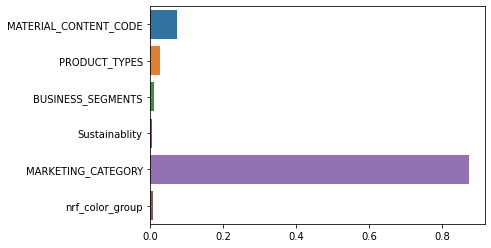

In [46]:
est_rf = GradientBoostingRegressor(max_depth=5, loss="absolute_error", verbose=1)

est_rf.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[MODEL_FEATURES])
rf_pred_test = est_rf.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, rf_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, rf_pred_test)}")

sns.barplot(x=est_rf.feature_importances_, y=MODEL_FEATURES)

Both are giving comparable results so let us stick to boosting for now as it ran faster than bagging.

There is a huge scope to fix the categorical encoder here as all the weight is going to `MARKETING_CATEGORY` here which is not ideal.

In [48]:
print(f"Training MAE: {mean_absolute_percentage_error(y_train, rf_pred_train)}")
print(f"Test MAE: {mean_absolute_percentage_error(y_test, rf_pred_test)}")

Training MAE: 0.8043986216299387
Test MAE: 0.9398620362824168


The model requires further tuning and more predictors clearly. The MAPE is really bad.
</br> Here are tuning ideas:

#TODO: Tuning ideas

In [ ]:
#TODO: Add requirements.txt

#TODO: Slides